In [51]:
import os
import copy
import glob

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d,splev,splrep
from scipy.ndimage import map_coordinates,gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import LogFormatter
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import hissw
from sunpy.map import Map

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA,InstrumentHinodeEIS
from synthesizAR.util import EISCube
from synthesizAR.atomic import EmissionModel

%matplotlib inline

# Emission Measure Analysis
Using the model of Hannah et al., perform an emission measure analysis of the forward-modeled AIA and EIS observations for the three different frequencies. We'll do this for the time-averaged EM distributions as well as a time dependent distribution. We'll also fit the EM slope between 1 MK and 4 MK to find the emission measure slope, $a$.

We'll look at the emission measure ($\mathrm{EM}$) distribution as constrained by

1. the intensity in each channel of SDO/AIA
2. the wavelength-resolved lines of _Hinode_/EIS

We'll compute these diagnostics, as a function of time, for all three runs: the low, intermediate, and high frequency cases and compare the results for all three heating functions.

We also want to compute the "true" emission measure distribution using the $n,T$ quantities we've computed at each grid point in the 3D AR.

## Emission Model
First, we need to load our emission model to see all of the lines we synthesized and the associated contribution functions.

In [2]:
emission_model = EmissionModel.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/emission_model1109_full/')

H I psplups file not found
He II psplups file not found
N VII psplups file not found
O VIII psplups file not found
Ne X psplups file not found
Na XI psplups file not found
Mg XII psplups file not found
Al XIII psplups file not found
Si XIV psplups file not found
P XV psplups file not found
S XVI psplups file not found
Cl XVII psplups file not found
Ar XVIII psplups file not found
K XIX psplups file not found
Ca XX psplups file not found
Fe XXVI psplups file not found
Ni XXVIII psplups file not found
He I psplups file not found
C V psplups file not found
N VI psplups file not found
O VII psplups file not found
Ne IX psplups file not found
Na X psplups file not found
Mg XI psplups file not found
Al XII psplups file not found
Si XIII psplups file not found
P XIV psplups file not found
S XV psplups file not found
Cl XVI psplups file not found
Ar XVII psplups file not found
K XVIII psplups file not found
Ca XIX psplups file not found
Fe XXV psplups file not found
Ni XXVII psplups file not f

Collect all of the resolved wavelengths into one list.

In [3]:
resolved_wavelengths = [(ion.chianti_ion.meta['name'],rw) for ion in emission_model.ions for rw in ion.resolved_wavelengths]

## Choose Spatial Location
We'll try to choose approximately the same location as that in Warren et al. for AR NOAA1109. We'll plot an actual AIA observation and draw a few boxes to try to find the actual location in (in pixel coordinates).

In [4]:
aia_observation = (Map('/home/wtb2/sunpy/data/aia_lev1_94a_2010_09_29t23_50_50_12z_image_lev1.1.fits')
                   .submap(u.Quantity([110,610]*u.arcsec),u.Quantity([10,510]*u.arcsec)))

In [5]:
left_x = 350*u.arcsec
bottom_y = 265*u.arcsec
width = 20*u.arcsec
height = 15*u.arcsec
right_x = left_x + width
top_y = bottom_y + height

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/sunpy/map/mapbase.py:1588: Warning: This map is not properly oriented. Plot axes may be incorrect
  Warning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/sunpy/map/mapbase.py:1593: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


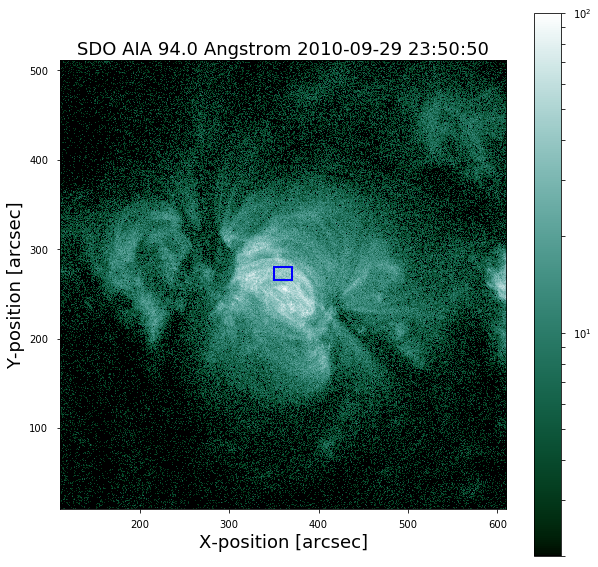

In [6]:
fig = plt.figure(figsize=(10,10))
im = aia_observation.plot(axes=fig.gca(),
                     norm=matplotlib.colors.SymLogNorm(2,vmin=2,vmax=100))
aia_observation.draw_rectangle(u.Quantity([left_x,bottom_y]),
                               width,
                               height,
                               color='b',lw=2)
fig.colorbar(im)

Now, pull in a sample synthesized image and convert these coordinates to pixel coordinates for both the AIA and EIS cases.

In [7]:
eis_simulation = EISCube('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_high_frequency/Hinode_EIS/170-210/map_t000750.h5')

In [8]:
aia_simulation = Map('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_high_frequency/SDO_AIA/94/map_t000750.fits')

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/sunpy/map/mapbase.py:1593: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


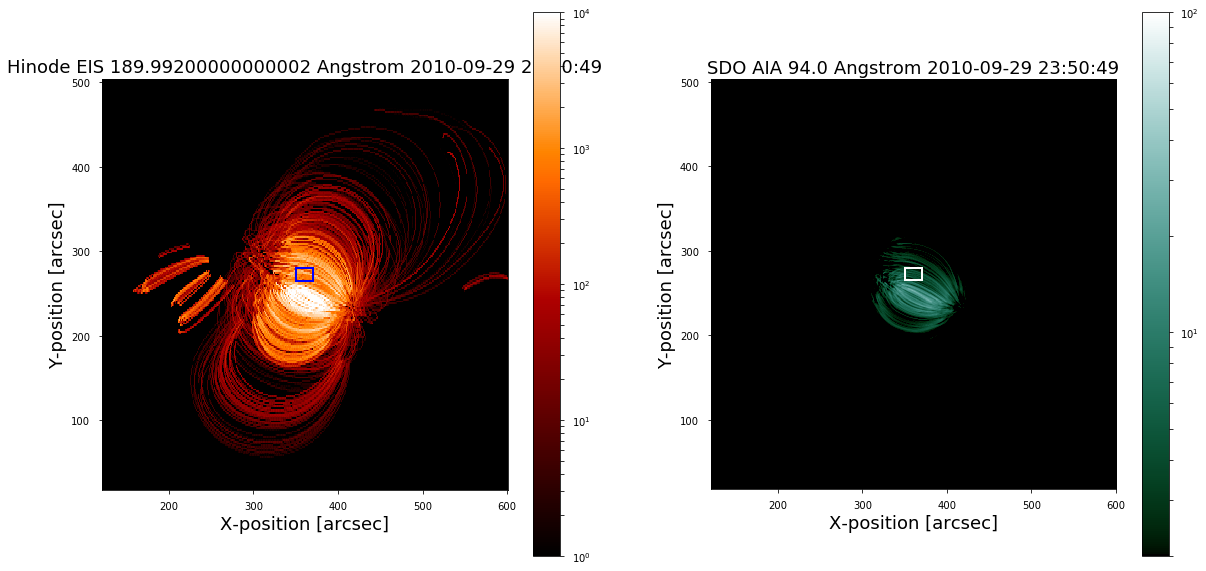

In [9]:
fig,axes = plt.subplots(1,2,figsize=(20,10))
eis_map = eis_simulation.integrated_intensity
im_eis = eis_map.plot(axes=axes[0],norm=matplotlib.colors.SymLogNorm(1e-5,vmin=1,vmax=1e4))
im_aia = aia_simulation.plot(axes=axes[1],norm=matplotlib.colors.SymLogNorm(1e-5,vmin=2,vmax=1e2))
eis_map.draw_rectangle(u.Quantity([left_x,bottom_y]),
                       width,
                       height,
                       color='b',lw=2,axes=axes[0])
aia_simulation.draw_rectangle(u.Quantity([left_x,bottom_y]),
                              width,
                              height,
                              color='w',lw=2,axes=axes[1])
fig.colorbar(im_eis,ax=axes[0])
fig.colorbar(im_aia,ax=axes[1])

In [10]:
# convert to pixel coordinates here if needed
# note that if the image is cropped or resampled in any way, this conversion no longer holds
# AIA
left_x_pixel_aia,bottom_y_pixel_aia = aia_simulation.data_to_pixel(left_x,bottom_y)
right_x_pixel_aia,top_y_pixel_aia = aia_simulation.data_to_pixel(right_x,top_y)

## IDL Setup for Regularized Inversion code
Setup the script to run the inversion code for both the AIA and EIS observations. Note that this uses the "old" method of Hannah and Kontar with very crude estimates of the intensity noise. 

In [11]:
demreg_script = """
; load intensity from each channel/line
names = {{ names }}
intensity = {{ intensity }}
; load the contribution functions or response functions (called K in Hannah and Kontar 2012)
k_matrix = {{ k_matrix }}
; load temperature array over which K is computed
log_temperature = {{ log_temperature }}

; temperature bins
temperature_bins = {{ temperature_bins }}

; crude estimate of intensity errors
intensity_errors = intensity*{{ error_ratio }}

; inversion method parameters
reg_tweak={{ reg_tweak }}
timed={{ timed }}
gloci={{ gloci }}

; run the inversion method
dn2dem_pos_nb,intensity,intensity_errors,$
              k_matrix,log_temperature,temperature_bins,$
              dem,edem,elogt,chisq,dn_reg,$
              timed=timed,gloci=gloci,reg_tweak=reg_tweak
"""

In [12]:
demreg_runner = hissw.ScriptMaker(extra_paths=['/home/wtb2/Documents/codes/demreg/idl/'])

In [13]:
save_vars = ['dem','edem','elogt','chisq','dn_reg']

Create a structure for saving the data.

In [14]:
class DEMResults(object):
    
    def __init__(self,dem_results,temperature_bins):
        self.temperature_bins = temperature_bins
        self.temperature_bin_centers = (temperature_bins[:-1] + temperature_bins[1:])/2.
        self.temperature_error_plus = self.temperature_bin_centers*(10.**(dem_results['elogt']) - 1.)
        self.temperature_error_minus = self.temperature_bin_centers*(1. - 10.**(-dem_results['elogt']))
        self.dem = dem_results['dem']
        self.em = dem_results['dem']*np.diff(temperature_bins)
        self.dem_errors = dem_results['edem']
        self.em_errors = np.diff(temperature_bins)*dem_results['edem']
        self.chi_squared = dem_results['chisq']
        self.regularized_data = dem_results['dn_reg']
        
    def fit_cool(self,logTa=6.0,logTb=6.6,use_positive=True):
        interval_index = np.where(np.logical_and(np.log10(self.temperature_bin_centers)>=logTa,
                                                 np.log10(self.temperature_bin_centers)<=logTb))
        if len(interval_index[0]) == 0:
            raise ValueError('No fit possible')
        logT_fit = np.float64(np.log10(self.temperature_bin_centers[interval_index]))
        logEM_fit = np.float64(np.log10(self.em[interval_index]))
        popt,popcov = curve_fit(self._linear_fit,logT_fit,logEM_fit)
        
        self.a = popt[0]
        self.fit_x_cool = 10.**logT_fit
        self.fit_y_cool = 10.**(self._linear_fit(logT_fit,*popt))
        
    def fit_hot(self,logTa=6.0,logTb=6.6,use_positive=True):
        interval_index = np.where(np.logical_and(np.log10(self.temperature_bin_centers)>=logTa,
                                                 np.log10(self.temperature_bin_centers)<=logTb))
        if len(interval_index[0]) == 0:
            raise ValueError('No fit possible')
        logT_fit = np.float64(np.log10(self.temperature_bin_centers[interval_index]))
        logEM_fit = np.float64(np.log10(self.em[interval_index]))
        popt,popcov = curve_fit(self._linear_fit,logT_fit,logEM_fit)
        
        self.b = popt[0]
        self.fit_x_hot = 10.**logT_fit
        self.fit_y_hot = 10.**(self._linear_fit(logT_fit,*popt))
        
    def _linear_fit(self,x,a,b):
        return a*x + b

## SDO/AIA Data
First, we need to extract the intensities for each channel for the region of interest and format the temperature response functions appropriately.

In [15]:
aia = InstrumentSDOAIA([7.5e3,1e4]*u.s)
aia_temperature = np.logspace(4.5,8,100)
aia_map_file_template = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_{frequency}_frequency/SDO_AIA/{channel}/map_t{i_time:06d}.fits'

First, we'll use a simple EM Loci method to estimate the shape of the emission measure distribution. Recalling that the intensity, in units of DN pixel$^{-1}$ s$^{-1}$, for a particular channel $i$ is given by,

$$
I_i = \int\mathrm{d}T\mathrm{DEM}(T)K_i(T)
$$

Taking the plasma to be isothermal over a discrete number of temperature bins defined by the sensitivity of the response function for a set of lines, we can take $K_i$ outside of the integral and "invert" the equation to give the emission measure distribution in the temperature bin for the channel $i$, 

$$
\mathrm{EM} = \int_{LOS}\mathrm{d}h\,n_e^2 = \frac{I_i}{K_i(T)}.
$$

Doing this for all the AIA channels gives a rough estimate of emission measure distribution. We'll calculate the time-averaged intensity from $t=7500$ s to $t=1\times10^4$ s.

In [16]:
intensities = {'high':{},'intermediate':{},'low':{}}

In [17]:
for frequency in intensities:
    for channel in aia.channels:
        average_intensity = 0.0 
        for i,_ in enumerate(aia.observing_time):
            average_intensity += (Map(aia_map_file_template.format(frequency=frequency,channel=channel['name'],i_time=i+750))
                                  .submap(u.Quantity([left_x,right_x]),u.Quantity([bottom_y,top_y]))
                                  .data
                                  .mean(axis=(0,1))
                                  )
        average_intensity /= aia.observing_time.shape[0]
        intensities[frequency][channel['name']] = average_intensity

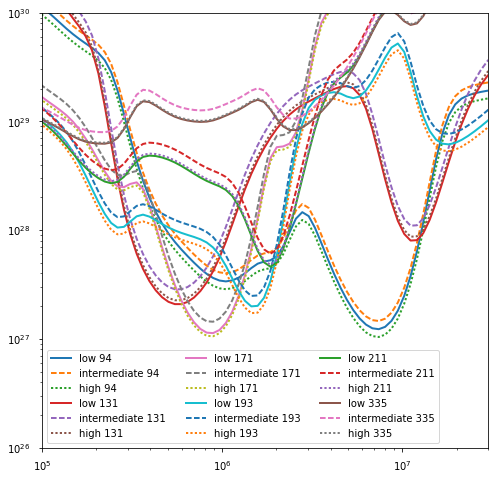

In [18]:
plt.figure(figsize=(8,8))
for channel in aia.channels:
    tresp = splev(aia_temperature,channel['temperature_response_spline'])
    for frequency,ls in zip(['low','intermediate','high'],['-','--',':']):
        plt.plot(aia_temperature,intensities[frequency][channel['name']]/tresp,
                 label='{} {}'.format(frequency,channel['name']),ls=ls)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e26,1e30])
plt.xlim([1e5,3e7])
plt.legend(loc='best',ncol=3)

Comparing the three frequencies, there don't seem to be a lot of differences in the EM distributions. We'll run the  EM inversion code on intensities as measured by AIA for time averages over 2500 s for each of the frequencies and then compare the emission measure distributions.

Set some parameters to be used in the inversion method. 

In [19]:
response_functions = [splev(aia_temperature,channel['temperature_response_spline']).tolist() for channel in aia.channels]
channel_names = [channel['name'] for channel in aia.channels]

In [28]:
temperature_bins = 10.**(np.arange(5.5,7.5,0.1))
static_input_vars = {'names':channel_names,'k_matrix':response_functions,
                     'log_temperature':np.log10(aia_temperature).tolist(),
                     'temperature_bins':temperature_bins.tolist(),
                     'error_ratio':0.3,
                     'gloci':1,'timed':1,'reg_tweak':1
                    }

In [29]:
dem_results = {}

Run the inversion code.

In [30]:
for frequency in intensities:
    # set input arrays
    input_vars = static_input_vars.copy()
    input_vars['intensity'] = [intensities[frequency][channel['name']] for channel in aia.channels]
    # call inversion method
    demreg_results = demreg_runner.run([(demreg_script,input_vars)],save_vars=save_vars,cleanup=True,verbose=False)
    # store results
    dem_results[frequency] = DEMResults(demreg_results,temperature_bins)

Plot the results for all of the frequencies.

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


(100000.0, 50000000.0)

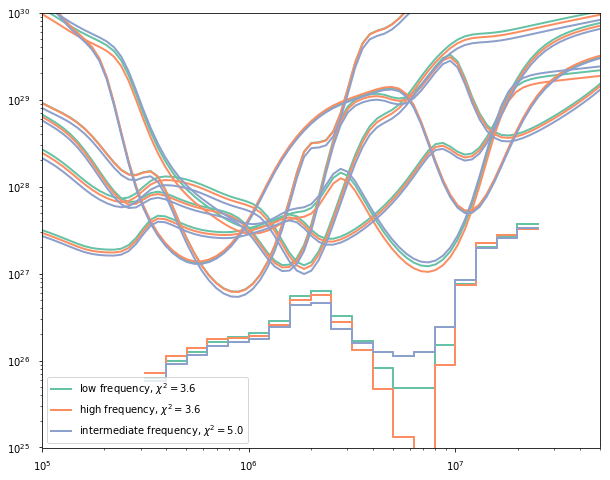

In [31]:
plt.figure(figsize=(10,8))
for color,frequency in zip(sns.color_palette('Set2'),dem_results):
    plt.step(dem_results[frequency].temperature_bins[:-1],dem_results[frequency].em,
             where='post',color=color,ls='-',lw=2,
             label=r'{} frequency, $\chi^2={:.1f}$'.format(frequency,dem_results[frequency].chi_squared[0]))
    plt.step(dem_results[frequency].temperature_bins[1:],dem_results[frequency].em,
             where='pre',color=color,ls='-',lw=2)

    for i,channel in enumerate(aia.channels):
        plt.plot(aia_temperature,
                 dem_results[frequency].regularized_data[i]/splev(aia_temperature,channel['temperature_response_spline']),
                 color=color,ls='-',alpha=1.)
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e25,1e30])
plt.xlim([1e5,5e7])

## _Hinode_/EIS Data
Run the EM inversion code on intensities as measured by EIS. This uses the contribution functions for the wavelength-resolved ions in our emission model.

In [219]:
eis = InstrumentHinodeEIS([7.5e3,1e4]*u.s)
eis_file_template = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_{frequency}_frequency/Hinode_EIS/{channel}/map_t{i_time:06d}.h5'

First we need to calculate the contribution functions for resolved lines we'll be using. The interpolation of the emissivities has to be hacked a bit, but this isn't necessarily a bad way of doing it...

In [220]:
pressure_const = 1e15*u.K*u.cm**(-3)
class FakeLoop(object):
    temperature = np.logspace(5.0,8.0,150)*u.K
    density = pressure_const/temperature
    
fake_loop = FakeLoop()
i_temperature,i_density = emission_model.interpolate_to_mesh_indices(fake_loop)

In [221]:
contribution_functions = {}
for ion in emission_model.ions:
    for rw in ion.resolved_wavelengths:
        i_rw = np.where(ion.wavelength==rw)[0][0]
        emiss = map_coordinates(ion.emissivity[:,:,i_rw].value,
                                np.vstack([i_temperature,i_density]),order=3)*ion.emissivity.unit
        ioneq = splev(fake_loop.temperature.value,
                      splrep(emission_model.temperature_mesh[:,0].value,
                             ion.fractional_ionization[:,0].value,k=1),ext=1)
        key = '{}_{}'.format(ion.chianti_ion.meta['name'],rw.value)
        contribution_functions[key] = (rw,(1./(np.pi*4.*u.steradian)*0.83
                                           *ioneq*ion.chianti_ion.abundance*emiss/fake_loop.density
                                           *(const.h.cgs*const.c.cgs)/rw.to(u.cm)/u.photon
                                          )
                                      )

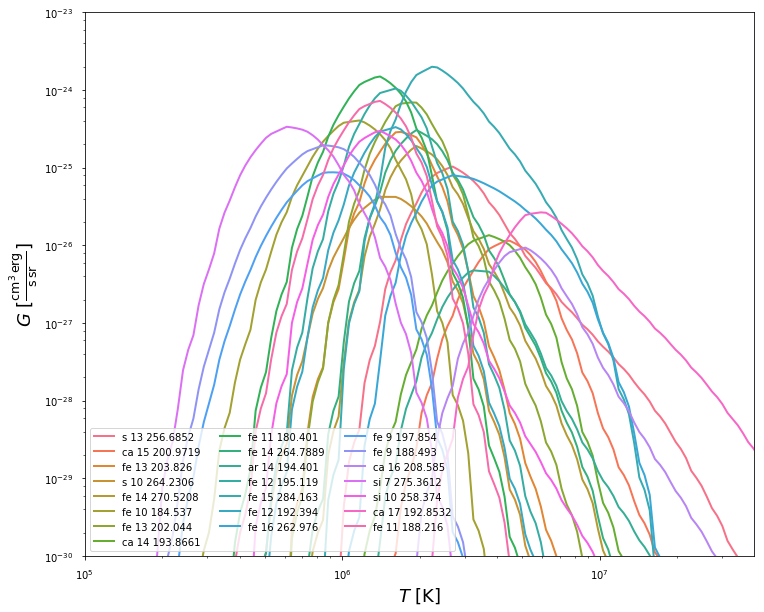

In [222]:
gofnt_colors = {k : sns.color_palette('husl',len(contribution_functions))[i] 
                for i,k in enumerate(contribution_functions)}
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
for k in contribution_functions:
    ax.plot(fake_loop.temperature,contribution_functions[k][1],
            color=gofnt_colors[k],alpha=1.,label='{} {} {}'.format(*(k.split('_'))))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-30,1e-23])
ax.set_xlim([10**(5.0),10**(7.6)])
ax.set_xlabel(r'$T$ [{:latex}]'.format(fake_loop.temperature.unit))
ax.set_ylabel(r'$G$ [{:latex}]'.format(contribution_functions[k][1].unit))
ax.legend(loc=3,ncol=3)

Next, we need to calculate the (integrated) intensity, averaged over the desired spatial region, for each of the lines. This needs to be done for each frequency and for each timestep.

What would happen though if we only used a subset of the ions?

In [197]:
accept_these_ions = ['si_7_275.3612',
                     'fe_10_184.537',
                     'fe_12_195.119',
                     'ca_17_192.8532',
                     'ca_14_193.8661',
                     'fe_9_188.493',
                     's_13_256.6852',
                     'ca_15_200.9719',
                     'fe_15_284.163'
                    ]

In [198]:
# Fix timestep for now, iterate over them later
# For the time iteration, use a list of dictionaries, will make extending everything very easy
intensities = {freq:{} for freq in ['high','intermediate','low']}
for freq in intensities:
    for channel in eis.channels:
        # load cube
        cube = EISCube(eis_file_template.format(frequency=freq,channel=channel['name'],i_time=999))
        # convert to physical coordinates
        interpolated_response = splev(cube.wavelength.value,
                                      splrep(channel['response']['x'].value,channel['response']['y'].value),
                                      ext=1)*channel['response']['y'].unit
        photons2erg = const.h.cgs*const.c.cgs/cube.wavelength.to(u.cm)/u.photon
        cube = cube*(1./interpolated_response)*photons2erg
        for ion in emission_model.ions:
            for rw in ion.resolved_wavelengths:
                #if '{}_{}'.format(ion.chianti_ion.meta['name'],rw.value) not in accept_these_ions:
                #    continue
                if cube.wavelength[0] <= rw <= cube.wavelength[-1]:
                    i_wave = np.argwhere(np.isclose(cube.wavelength.value,rw.value,rtol=0.0,atol=1.1e-2))[0][0]
                    tmp = cube[i_wave-10:i_wave+10].integrated_intensity
                    key = '{}_{}'.format(ion.chianti_ion.meta['name'],rw.value)
                    intensities[freq][key] = (tmp
                                              .submap(u.Quantity([left_x,right_x])+u.Quantity([-50,50],u.arcsec),
                                                      u.Quantity([bottom_y,top_y])+u.Quantity([-50,50],u.arcsec))
                                              .data
                                              .mean()*u.Unit(tmp.meta['bunit']))
    

Finally, plot the EM loci curves for each line.

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/astropy/units/quantity.py:951: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)


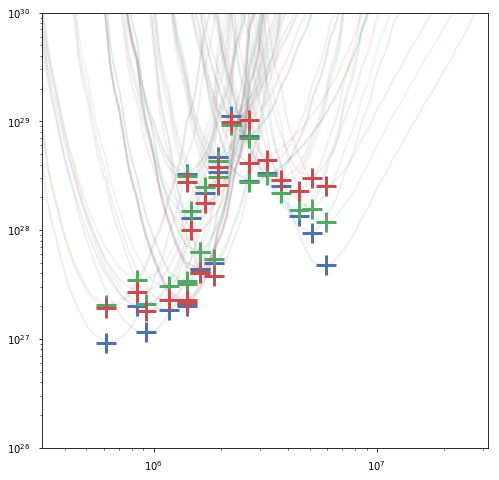

In [199]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
for freq,color in zip(['high','intermediate','low'],sns.color_palette('deep')):
    for key in contribution_functions:
        em_loci = intensities[freq][key]/contribution_functions[key][1]
        ax.plot(fake_loop.temperature,em_loci,
                color=color,alpha=0.1,lw=2)
        ax.plot(fake_loop.temperature[np.argmin(em_loci)],np.min(em_loci),
                marker='+',color=color,markersize=20,mew=3,ls='')
ax.set_ylim([1e26,1e30])
ax.set_xlim([10**(5.5),10**(7.5)])
ax.set_yscale('log')
ax.set_xscale('log')

Now we need to run the actual DEM code on our synthesized data. First, configure some basic inputs for running the regularized inversion code. 

In [200]:
temperature_bins = 10.**(np.arange(5.6,7.1,0.05))
static_input_vars = {
                     'log_temperature':np.log10(fake_loop.temperature.value).tolist(),
                     'temperature_bins':temperature_bins.tolist(),
                     'error_ratio':0.25,
                     'gloci':1,'reg_tweak':1,'timed':1
                    }

In [201]:
len(temperature_bins) > len(accept_these_ions)

True

Now iterate through each timestep and frequency and run the inversion code using each of our resolved lines. We really should be taking a time average here. This is what we did with the AIA results. However, loading in this data takes a long time.

In [202]:
dem_results_eis = {}

In [203]:
# iterate through time once we are ready to do this
for freq in ['high','intermediate','low']:
    # format the names, contribution functions, and intensities
    gofnt_array,line_names,intensity_array = [],[],[]
    for key in contribution_functions:
        gofnt_array.append(contribution_functions[key][1].value.tolist())
        line_names.append('{}_{}'.format(*(key.split('_')[:-1])))
        intensity_array.append(intensities[freq][key].value)
    # make input variables
    input_vars = static_input_vars.copy()
    input_vars['intensity'] = intensity_array
    input_vars['names'] = line_names
    input_vars['k_matrix'] = gofnt_array
    # run demreg code
    tmp = demreg_runner.run([(demreg_script,input_vars)],save_vars=save_vars,cleanup=True,verbose=False)
    # save results
    tmp_dem_results = DEMResults(tmp,temperature_bins)
    tmp_dem_results.fit_cool(logTb=6.5,logTa=6.0)
    tmp_dem_results.fit_hot(logTb=7.,logTa=6.5)
    dem_results_eis[freq] = tmp_dem_results

We'd now like to compare these regularized DEMs with the true DEMs as determined by our simulations.

In [194]:
true_dems = {}
aia_true = InstrumentSDOAIA([0,2e4]*u.s)
eis_true = InstrumentHinodeEIS([0,2e4]*u.s)
root_dir = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_{}_frequency/'

In [195]:
for freq in ['low','intermediate','high']:
    field = synthesizAR.Skeleton.restore(os.path.join(root_dir.format(freq),'field_checkpoint/'))
    observer = synthesizAR.Observer(field,[aia_true,eis_true],ds=field._convert_angle_to_length(0.4*u.arcsec))
    observer.build_detector_files(root_dir.format(freq))
    em_cube = observer.make_emission_measure_map(eis_true.observing_time[999],
                                                 eis_true,
                                                 temperature_bin_edges=temperature_bins*u.K)
    true_dems[freq] = em_cube.get_1d_distribution(u.Quantity([left_x,right_x])+u.Quantity([-50,50],u.arcsec),
                                                  u.Quantity([bottom_y,top_y])+u.Quantity([-50,50],u.arcsec))

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-05-17 17:44:19,633 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-05-17 17:44:19,634 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-05-17 17:44:19,635 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-05-17 17:44:19,636 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-05-17 17:44:19,636 Parameters: cosmological_simulation   = 0.0
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/s

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in true_divide


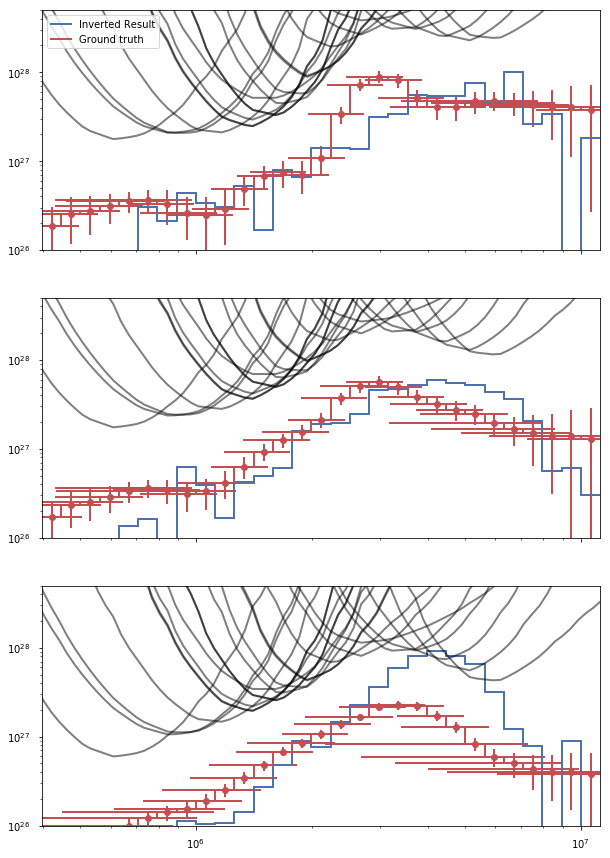

In [218]:
fig,axes = plt.subplots(3,1,figsize=(10,15),sharex=True,sharey=True)
for ax,(i,freq) in zip(axes.flatten(),enumerate(['low','intermediate','high'])):
    # True emission mesure distributions
    ax.step(true_dems[freq][0][:-1],true_dems[freq][1],where='post',
            color=sns.color_palette('deep')[0],label=r'Inverted Result')
    ax.step(true_dems[freq][0][1:],true_dems[freq][1],where='pre',
            color=sns.color_palette('deep')[0])
    # Regularized results with error bars
    ax.errorbar(dem_results_eis[freq].temperature_bin_centers,
                dem_results_eis[freq].em,
                xerr=[dem_results_eis[freq].temperature_error_plus,
                      dem_results_eis[freq].temperature_error_minus],
                yerr=dem_results_eis[freq].em_errors,
                 ls='',marker='o',color=sns.color_palette('deep')[2])
    # Histograms of regularized results
    ax.step(dem_results_eis[freq].temperature_bins[:-1],dem_results_eis[freq].em,
             where='post',color=sns.color_palette('deep')[2],ls='-',lw=2,label=r'Ground truth')
    ax.step(dem_results_eis[freq].temperature_bins[1:],dem_results_eis[freq].em,
             where='pre',color=sns.color_palette('deep')[2],ls='-',lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e26,5e28])
    ax.set_xlim([temperature_bins[0],temperature_bins[-1]])
    # plot em loci 
    for j,k in enumerate(contribution_functions):
        ax.plot(fake_loop.temperature,
                 dem_results_eis[freq].regularized_data[j]/contribution_functions[k][1],
                 color='k',ls='-',alpha=0.5)
axes[0].legend(loc=2)

Now, plot the emission measure distributions for all three frequencies.

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(501187.23362727248, 16595869.074375665)

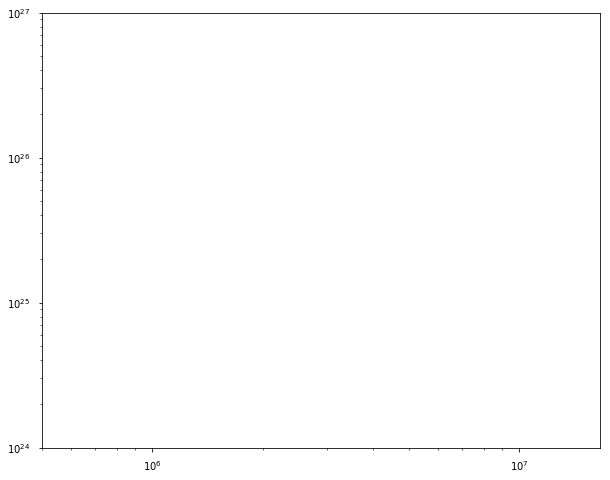

In [127]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
for color,frequency in zip(sns.color_palette('Set2'),dem_results_eis):
    # plot histograms
    #plt.step(dem_results_eis[frequency].temperature_bins[:-1],dem_results_eis[frequency].em,
    #         where='post',color=color,ls='-',lw=2,
    #         label=(r'{} frequency, $\chi^2={:.1f}$, $a={:.2f}$, $b={:.2f}$'
    #                .format(frequency,dem_results_eis[frequency].chi_squared[0],
    #                        dem_results_eis[frequency].a,dem_results_eis[frequency].b)))
    #plt.step(dem_results_eis[frequency].temperature_bins[1:],dem_results_eis[frequency].em,
    #         where='pre',color=color,ls='-',lw=2)
    # plot errorbars
    #plt.errorbar(dem_results_eis[frequency].temperature_bin_centers,
    #             dem_results_eis[frequency].em,
                 #xerr=[dem_results_eis[frequency].temperature_error_plus,
                 #      dem_results_eis[frequency].temperature_error_minus],
    #             yerr=dem_results_eis[frequency].em_errors,
    #             ls='',ecolor=color)
    # plot fit lines
    #plt.plot(dem_results_eis[frequency].fit_x_cool,
    #         dem_results_eis[frequency].fit_y_cool,'--b',lw=2)
    #plt.plot(dem_results_eis[frequency].fit_x_hot,
    #         dem_results_eis[frequency].fit_y_hot,'--r',lw=2)
    # plot histograms of true EM
    ax.step(true_dems[frequency][0][:-1],true_dems[frequency][1],
             where='post',color=color,ls='--',lw=2,alpha=0.5)
    ax.step(true_dems[frequency][0][1:],true_dems[frequency][1],
             where='pre',color=color,ls='--',lw=2,alpha=0.5)
    # plot em loci 
    #for i,k in enumerate(contribution_functions):
    #    plt.plot(fake_loop.temperature,
    #             dem_results_eis[frequency].regularized_data[i]/contribution_functions[k][1],
    #             color=color,ls='-',alpha=1.)
ax.legend(loc=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e24,1e27])
ax.set_xlim([np.min(temperature_bins),np.max(temperature_bins)])

It seems that doing a comparison at one particular point in time/space is difficult. Instead, we should aim to average over the relevant time period and look at *every* pixel in the map by constructing a map of the emission measure, both for the true and and regularized cases.

## 2D DEM Maps
Now, using both the AIA and EIS data, create a DEM map, at each pixel, from the results of the regularized inversion code. (Might have to move this to a separate notebook).